In [1]:
from sklearn.model_selection import train_test_split
from sklearn import datasets
import jax
import jax.numpy as jnp

iris = datasets.load_iris()

xs = iris.data
n_classes = max(iris.target) + 1
ys = jax.nn.one_hot(iris.target, n_classes)
xs = (xs - xs.mean(axis=0)) / xs.std(axis=0)

X_train, X_test, y_train, y_test = train_test_split(
    xs, ys, test_size=0.1, random_state=42
)


class MultinomialLogisticRegressor:
    def __init__(self, w, b):
        self.w = w
        self.b = b

    def predict(self, x):
        return jax.nn.softmax(jax.lax.batch_matmul(x, self.w) + self.b)

    @staticmethod
    def cross_entropy(logprobs, targets):
        target_class = jnp.argmax(targets, axis=1, keepdims=True)
        nll = jnp.take_along_axis(logprobs, target_class, axis=1)
        ce = -jnp.mean(nll)
        return ce


In [2]:
target_class = jnp.argmax(ys, axis=1, keepdims=True)
target_class.squeeze()


Array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], dtype=int32)

In [3]:
from sklearn.datasets import load_iris
from sklearn.linear_model import LogisticRegression

X, y = load_iris(return_X_y=True)
clf = LogisticRegression().fit(X, y)
clf.predict_proba(X[:2, :])


/Users/edeno/miniconda3/envs/test_hmm/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


array([[9.81772998e-01, 1.82269876e-02, 1.44088309e-08],
       [9.71687758e-01, 2.83122120e-02, 3.01162294e-08]])

In [4]:
from src.test_non_local_switching_non_stationary_model import load_data

is_ripple, spikes, position, speed, env, time = load_data(work_computer=False)


In [5]:
import numpy as np

np.logical_and(is_ripple[:-1], is_ripple[1:]).sum() / is_ripple[:-1].sum()


0.9797168390400642

In [6]:
from scipy.optimize import minimize
from src.estimate_transition import jax_centered_log_softmax_forward
import jax
import jax.numpy as jnp


@jax.jit
def multinomial_nll(
    coefficients: jnp.ndarray, design_matrix: jnp.ndarray, class_prob: jnp.ndarray
) -> float:
    """Multinomial negative log likelihood.

    Parameters
    ----------
    coefficients : jnp.ndarray, shape (n_coefficients * n_classes - 1,)
    design_matrix : jnp.ndarray, shape (n_samples, n_coefficients)
    class_prob : jnp.ndarray, shape (n_samples, n_classes)
        `class_prob` can either be the target class labels (use one hot encoding) or probability of labels.

    Returns
    -------
    negative_log_likelihood : float
    """
    n_coefficients = design_matrix.shape[1]
    coefficients = coefficients.reshape(
        (n_coefficients, -1)
    )  # (n_coefficients,  n_classes - 1)
    # cross entropy between actual and predicted class probabilities, shape (n_samples,)
    # linear predictor is shape (n_samples, n_classes - 1)
    # centered_log_softmax is shape (n_samples, n_classes)
    cross_entropy = (
        class_prob * jax_centered_log_softmax_forward(design_matrix @ coefficients)
    ).sum(axis=1)

    return -1.0 * jnp.mean(cross_entropy)


n_classes = 2

class_prob = jax.nn.one_hot(is_ripple[1:].astype(int), num_classes=n_classes).astype(
    float
)
design_matrix = is_ripple[:-1][:, None].astype(float)
n_coefficients = design_matrix.shape[1]

x0 = jnp.zeros((n_coefficients, n_classes - 1)).ravel()

# minimize negative log likelihood of multinomial logistic regression
res = minimize(
    multinomial_nll,
    x0=x0,
    jac=jax.grad(multinomial_nll),
    args=(
        design_matrix,
        class_prob,
    ),
    method="BFGS",
    options={"disp": True},
)


Optimization terminated successfully.
         Current function value: 0.680069
         Iterations: 8
         Function evaluations: 11
         Gradient evaluations: 11


In [7]:
res


      fun: 0.680069088935852
 hess_inv: array([[1831.72047785]])
      jac: array([7.3888177e-06], dtype=float32)
  message: 'Optimization terminated successfully.'
     nfev: 11
      nit: 8
     njev: 11
   status: 0
  success: True
        x: array([-3.8607139])

In [8]:
from src.hmm import centered_softmax_forward

centered_softmax_forward(x0.reshape((1, -1)))


array([[0.5, 0.5]])

In [9]:
from src.hmm import centered_softmax_forward

coefficients = res.x.reshape((1, -1))
centered_softmax_forward(coefficients)[0]


array([0.02061888, 0.97938112])

In [10]:
from sklearn.linear_model import LogisticRegression

sklearn_model = LogisticRegression(fit_intercept=False, penalty="none").fit(
    is_ripple[:-1][:, None], is_ripple[1:][:, None]
)


In [11]:
sklearn_model.predict_proba(np.array([1])[:, None])


array([[0.02028318, 0.97971682]])

In [12]:
sklearn_model.coef_


array([[3.87747155]])

In [13]:
import optax


@jax.jit
def nll(coefficients, design_matrix, class_prob):
    return optax.softmax_cross_entropy(
        jnp.column_stack(
            (
                (
                    design_matrix @ coefficients.reshape((n_coefficients, -1)),
                    jnp.zeros((design_matrix.shape[0], 1)),
                )
            )
        ),
        class_prob,
    ).mean()


res = minimize(
    multinomial_nll,
    x0=x0,
    jac=jax.grad(multinomial_nll),
    hess=jax.hessian(multinomial_nll),
    args=(
        design_matrix,
        class_prob,
    ),
    method="Newton-CG",
    options={
        "disp": True,
        "gtol": 1e-05,
        "maxiter": 100,
    },
)

res.x


Optimization terminated successfully.
         Current function value: 0.680069
         Iterations: 6
         Function evaluations: 6
         Gradient evaluations: 6
         Hessian evaluations: 6


array([-3.8762884], dtype=float32)

In [14]:
from src.hmm import centered_softmax_forward

centered_softmax_forward(res.x.reshape((1, -1)))


array([[0.02030671, 0.97969329]])

In [15]:
from statsmodels.discrete.discrete_model import MNLogit

sm_results = MNLogit(is_ripple[1:] * 0.9, is_ripple[:-1]).fit(method="newton")


/Users/edeno/miniconda3/envs/test_hmm/lib/python3.10/site-packages/statsmodels/discrete/discrete_model.py:4206: SpecificationWarning: endog contains values are that not int-like. Uses string representation of value. Use integer-valued endog to suppress this warning.
  warnings.warn(msg, SpecificationWarning)


Optimization terminated successfully.
         Current function value: 0.680069
         Iterations 8


In [16]:
sm_results.params


array([[3.87747256]])

In [17]:
sm_results.predict(np.ones((1, 1)))


array([[0.02028316, 0.97971684]])

In [18]:
sm_results = MNLogit(is_ripple[1:], is_ripple[:-1]).fit(method="bfgs")
sm_results.params


Optimization terminated successfully.
         Current function value: 0.680069
         Iterations: 8
         Function evaluations: 11
         Gradient evaluations: 11


array([[3.86070719]])

In [19]:
sm_results.predict(np.ones((1, 1)))


array([[0.02061901, 0.97938099]])

In [ ]:
@jax.jit
def nll(coefficients, design_matrix, class_prob):
    linear_predictor = design_matrix @ coefficients.reshape((n_coefficients, -1))
    return jnp.smultino

In [20]:
from patsy import dmatrix
from statsmodels.tsa.tsatools import lagmat
from src.test_non_local_switching_non_stationary_model import estimate_no_spike_times
from src.hmm import centered_softmax_forward

speed_knots = [0.5, 2.0, 4.0, 8.0, 16.0, 32.0, 64.0, 128.0, 256.0]
data = {"speed": lagmat(speed, maxlag=1)}
formula = f"1 + bs(speed, knots={speed_knots})"
design_matrix = dmatrix(formula, data)


low_spike_rate_threshold = 0.1
low_spike_smoothing_sigma = 0.015

is_no_spike_time = estimate_no_spike_times(
    spikes,
    speed,
    rate_threshold=low_spike_rate_threshold,
    sigma=low_spike_smoothing_sigma,
)
is_local_time = np.logical_and(~is_ripple, ~is_no_spike_time)

from_states = {
    "local": lagmat(is_local_time, maxlag=1).astype(bool).squeeze(),
    "no_spike": lagmat(is_no_spike_time, maxlag=1).astype(bool).squeeze(),
    "non_local": lagmat(is_ripple, maxlag=1).astype(bool).squeeze(),
}
n_states = 3
response = np.zeros((design_matrix.shape[0], n_states))
response[is_local_time.astype(bool), 0] = 1.0
response[is_no_spike_time.astype(bool), 1] = 1.0
response[is_ripple.astype(bool), 2] = 1.0

n_time, n_coefficients = design_matrix.shape
starting_prob = jnp.zeros(
    (
        n_coefficients,
        n_states - 1,
    )
).ravel()
discrete_transition_coefficients = np.zeros((n_coefficients, n_states, n_states - 1))
discrete_transition = np.zeros((n_time, n_states, n_states))

for from_state_ind, (from_state, is_from_state) in enumerate(from_states.items()):
    print(from_state)
    res = minimize(
        multinomial_nll,
        x0=starting_prob,
        jac=jax.grad(multinomial_nll),
        hess=jax.hessian(multinomial_nll),
        args=(
            design_matrix[is_from_state],
            response[is_from_state],
        ),
        method="Newton-CG",
        options={
            "disp": True,
            "gtol": 1e-05,
            "maxiter": 100,
        },
    )
    discrete_transition_coefficients[:, from_state_ind, :] = res.x.reshape(
        (
            n_coefficients,
            n_states - 1,
        )
    )
    discrete_transition[:, from_state_ind, :] = centered_softmax_forward(
        design_matrix @ discrete_transition_coefficients[:, from_state_ind, :]
    )


local
Optimization terminated successfully.
         Current function value: 0.003711
         Iterations: 23
         Function evaluations: 23
         Gradient evaluations: 23
         Hessian evaluations: 23
no_spike
Optimization terminated successfully.
         Current function value: 0.296579
         Iterations: 13
         Function evaluations: 14
         Gradient evaluations: 14
         Hessian evaluations: 13
non_local
Optimization terminated successfully.
         Current function value: 0.099010
         Iterations: 12
         Function evaluations: 12
         Gradient evaluations: 12
         Hessian evaluations: 12


(80000.0, 100000.0)

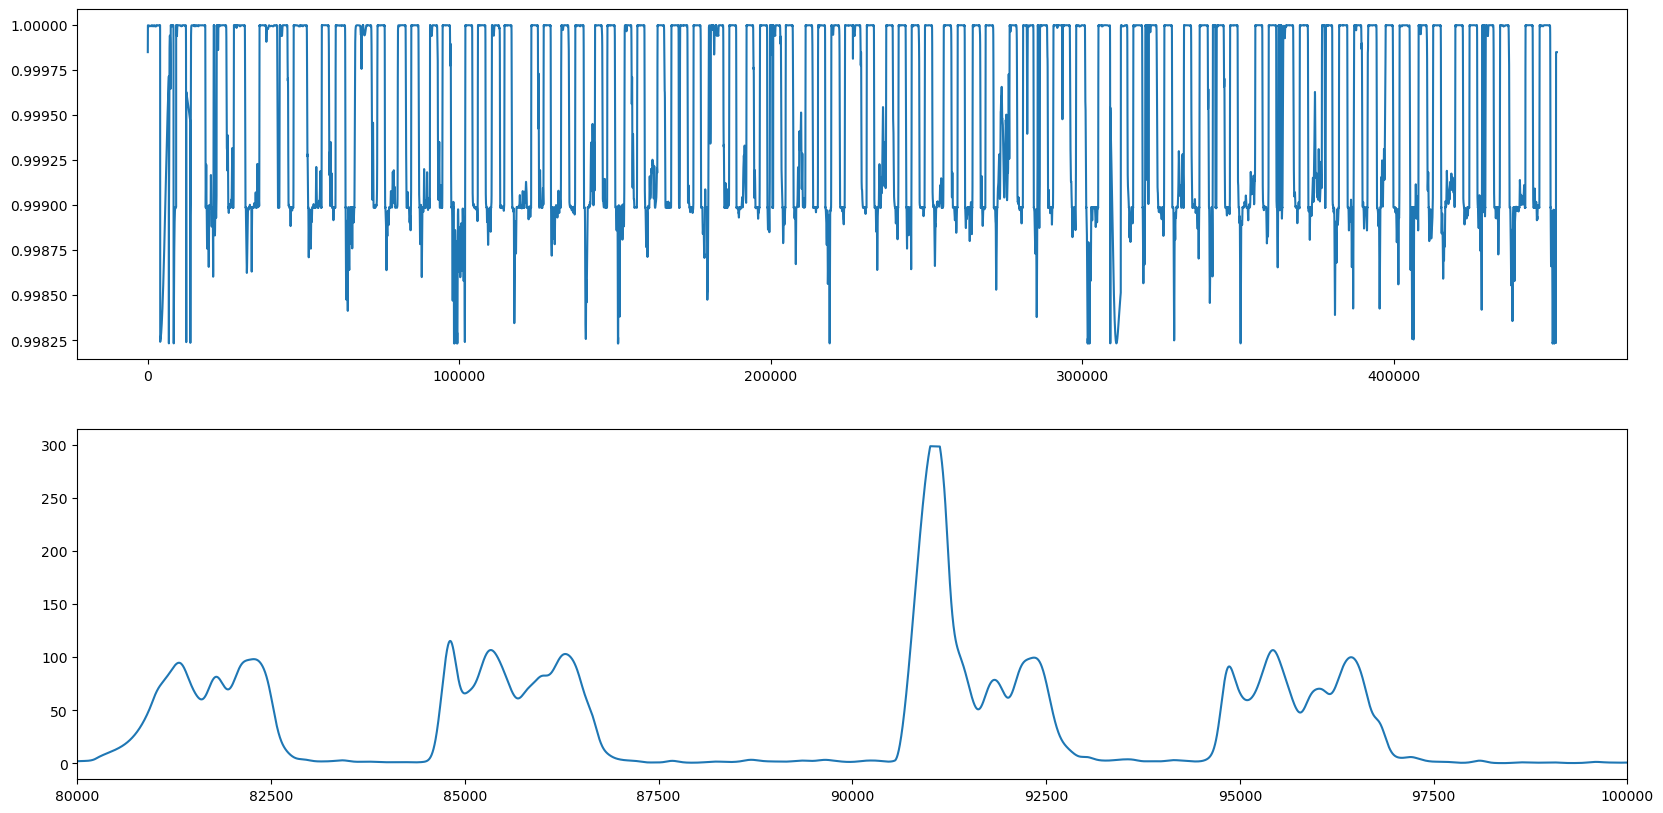

In [21]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(2, 1, figsize=(20, 10))

axes[0].plot(discrete_transition[:, 0, 0])
axes[1].plot(speed)

plt.xlim((80_000, 100_000))

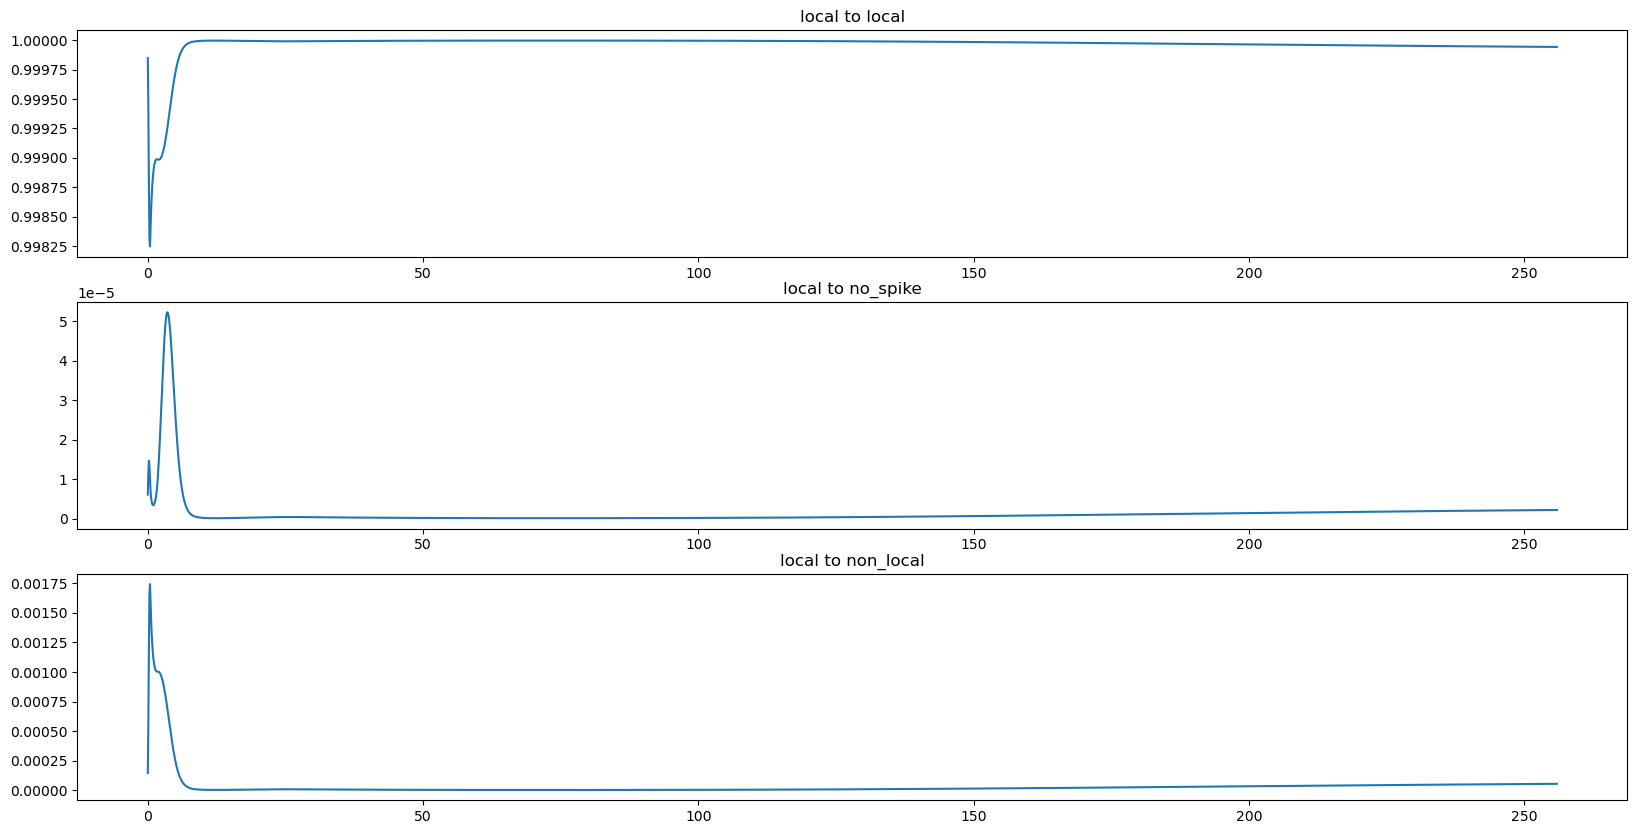

In [22]:
from patsy import build_design_matrices
predict_data = {"speed": np.arange(0, 256, 0.1)}

predict_design_matrix = build_design_matrices(
    [design_matrix.design_info], predict_data)[0]

prob_at_speed = centered_softmax_forward(predict_design_matrix @ discrete_transition_coefficients[:, 0, :])

fig, axes = plt.subplots(3, 1, figsize=(20, 10))
for i, (ax, from_state) in enumerate(zip(axes, from_states)):
    ax.plot(
        predict_data["speed"],
        prob_at_speed[:, i],
    )
    ax.set_title(f"local to {from_state}")